## Zobrazení poslední hodiny teplota_log.csv

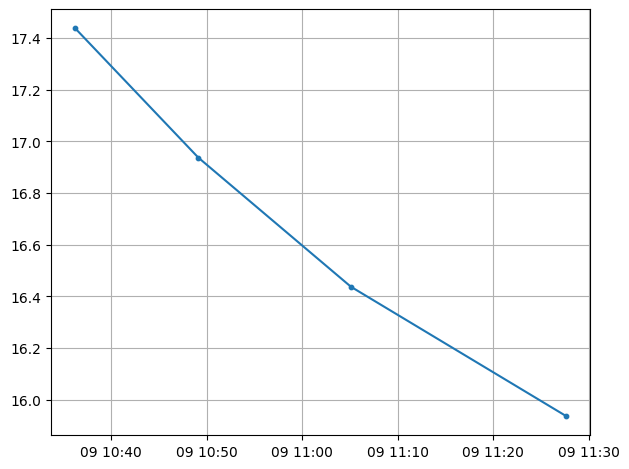

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [64]:
 
df_plot.tail(20)


,Time,Value
309,2026-02-09 10:36:16,17.437
310,2026-02-09 10:49:08,16.937
311,2026-02-09 11:05:06,16.437
312,2026-02-09 11:27:35,15.937


## Vytvoření df_netatmo ze souboru netatmo_data.csv

In [65]:
import pandas as pd

# Cesta k souboru
path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení dat - tentokrát bez skiprows, protože data začínají hned
df_netatmo = pd.read_csv(path)

# 1) převod z UNIX sekund na datetime
df_netatmo["timestamp"] = pd.to_datetime(df_netatmo["timestamp"], unit="s")

# 2) pokud chceš formátovaný textový sloupec
df_netatmo["timestamp_str"] = df_netatmo["timestamp"].dt.strftime("%d.%m.%Y %H:%M:%S")


# Ukázka dat
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str
176,2026-02-09 10:05:07,22.3,4.1,22,False,1011.6,09.02.2026 10:05:07
177,2026-02-09 10:10:08,22.3,4.2,22,False,1011.6,09.02.2026 10:10:08
178,2026-02-09 10:15:07,22.3,4.3,22,False,1011.6,09.02.2026 10:15:07
179,2026-02-09 10:20:08,22.3,4.4,22,False,1011.7,09.02.2026 10:20:08
180,2026-02-09 10:25:11,22.3,4.4,22,False,1011.7,09.02.2026 10:25:11
181,2026-02-09 10:27:28,22.3,4.5,22,False,1011.7,09.02.2026 10:27:28
182,2026-02-09 10:30:08,22.3,4.6,22,False,1011.7,09.02.2026 10:30:08
183,2026-02-09 10:35:06,22.3,4.7,22,False,1011.7,09.02.2026 10:35:06
184,2026-02-09 10:40:07,22.3,4.7,22,False,1011.7,09.02.2026 10:40:07
185,2026-02-09 10:45:08,22.3,4.8,22,False,1011.7,09.02.2026 10:45:08


## Zobrazení ekvitermních křivek

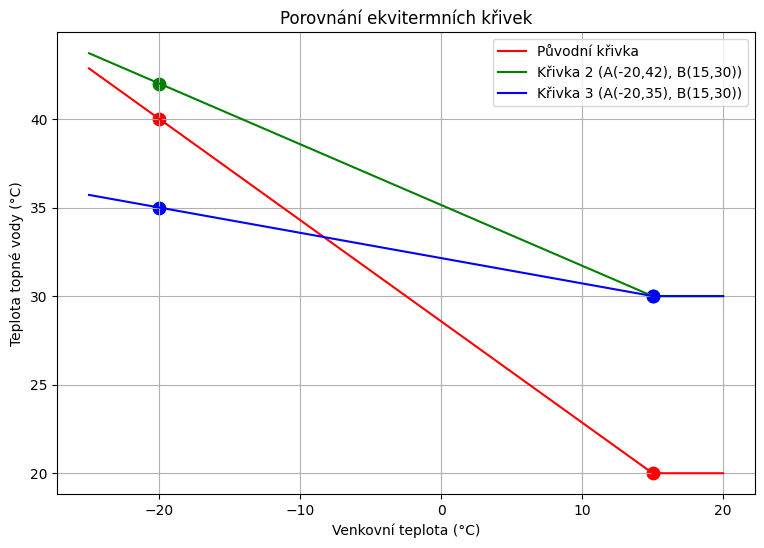

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# 2) Druhá křivka (A(-20,42), B(15,30) – tvoje stará verze)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# 3) Nová křivka podle bodů A(-20,35) a B(15,30)
def hokejka3(temp_in):
    if temp_in <= 15:
        return -0.142857 * temp_in + 32.14286
    else:
        return 30

# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]
temps_out_3 = [hokejka3(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Křivka 2 (A(-20,42), B(15,30))", color="green")
plt.plot(temps_in, temps_out_3, label="Křivka 3 (A(-20,35), B(15,30))", color="blue")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80)

# Body křivky 2
plt.scatter([-20, 15], [42, 30], color="green", s=80)

# Body křivky 3
plt.scatter([-20, 15], [35, 30], color="blue", s=80)

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

plt.show()


### Výpočet boiler_water_2 z temp_outdoor v df_netatmo, který byl vytvořen výše

In [74]:
import pandas as pd

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/40) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# Sloupec Boiler_water
# df_netatmo["Boiler_water"] = df_netatmo["temp_outdoor"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temp_outdoor"].apply(hokejka2)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str,Boiler_water_2
176,2026-02-09 10:05:07,22.3,4.1,22,False,1011.6,09.02.2026 10:05:07,33.737286
177,2026-02-09 10:10:08,22.3,4.2,22,False,1011.6,09.02.2026 10:10:08,33.703001
178,2026-02-09 10:15:07,22.3,4.3,22,False,1011.6,09.02.2026 10:15:07,33.668715
179,2026-02-09 10:20:08,22.3,4.4,22,False,1011.7,09.02.2026 10:20:08,33.634429
180,2026-02-09 10:25:11,22.3,4.4,22,False,1011.7,09.02.2026 10:25:11,33.634429
181,2026-02-09 10:27:28,22.3,4.5,22,False,1011.7,09.02.2026 10:27:28,33.600144
182,2026-02-09 10:30:08,22.3,4.6,22,False,1011.7,09.02.2026 10:30:08,33.565858
183,2026-02-09 10:35:06,22.3,4.7,22,False,1011.7,09.02.2026 10:35:06,33.531572
184,2026-02-09 10:40:07,22.3,4.7,22,False,1011.7,09.02.2026 10:40:07,33.531572
185,2026-02-09 10:45:08,22.3,4.8,22,False,1011.7,09.02.2026 10:45:08,33.497286


## Graf z df_netatmo

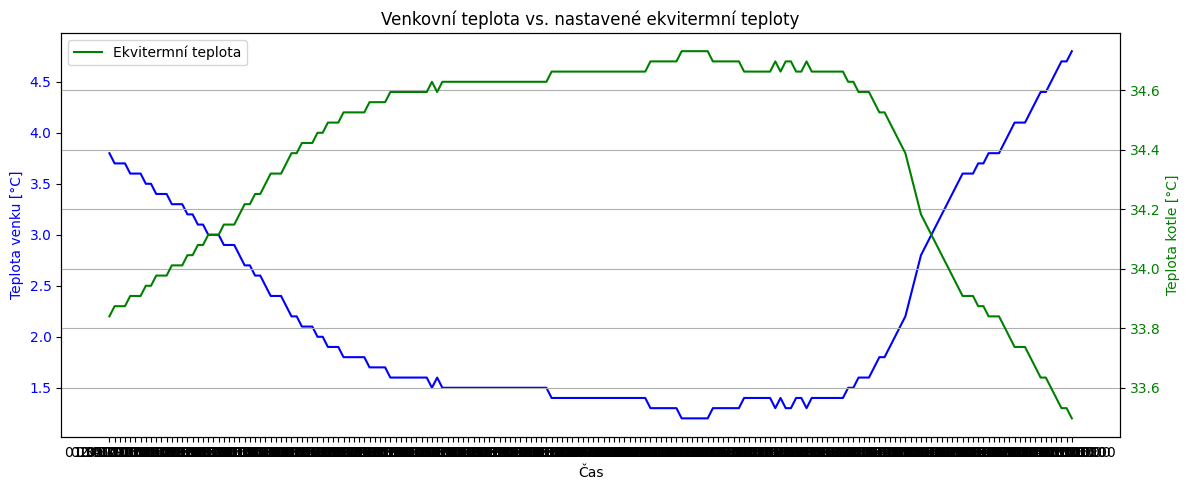

In [75]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

# Hlavní osa
ax = plt.gca()

# Venkovní teplota
ax.plot(df_netatmo["timestamp_str"], df_netatmo["temp_outdoor"], color="blue")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa (Boiler_water)
ax2 = ax.twinx()
# ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Teplota kotle 1")
ax2.plot(df_netatmo["timestamp_str"], df_netatmo["Boiler_water_2"], color="green", label="Ekvitermní teplota")

ax2.set_ylabel("Teplota kotle [°C]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titulek a popisky
plt.title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

# Legenda pro vedlejší osu
ax2.legend(loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()


## Starý soubor teplota_log_old1

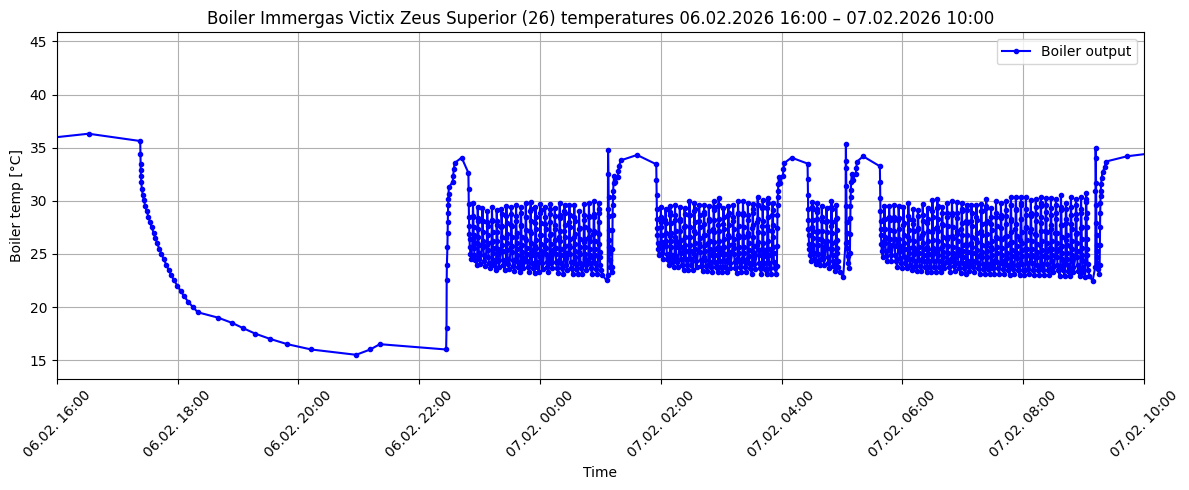

In [68]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


df_old = pd.read_csv("teplota_log_old1.csv", header=None, names=["Time", "Value"])
df_old["Time"] = pd.to_datetime(df_old["Time"], errors="coerce")
df_old["Value"] = pd.to_numeric(df_old["Value"], errors="coerce")
df_old = df_old.dropna().sort_values("Time").drop_duplicates("Time")

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-06 16:00:00")
end_time   = pd.Timestamp("2026-02-07 10:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df_old["Time"], df_old["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Nový soubor raspberry teplota_log.csv

KeyError: 'Time'

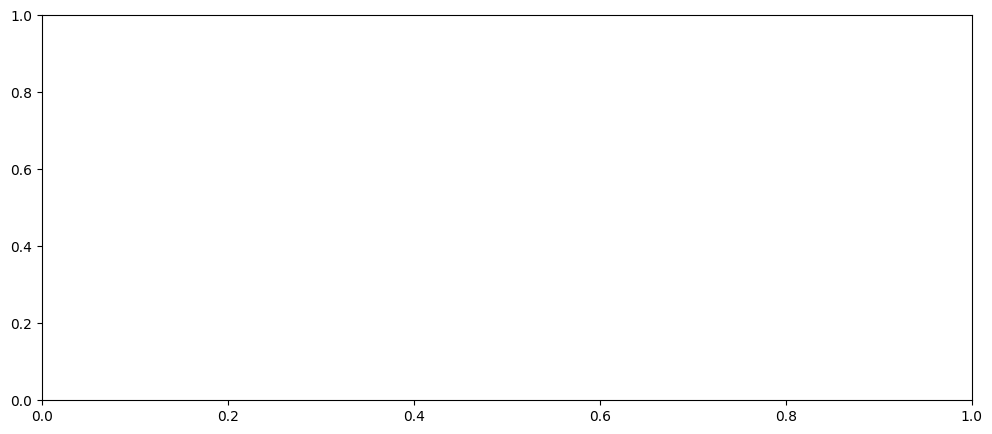

In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-08 16:00:00")
end_time   = pd.Timestamp("2026-02-09 11:00:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")
# Netatmo – nová křivka (Boiler_water_2)
ax.plot(df_netatmo["timestamp"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")


# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Teplota v prádelně

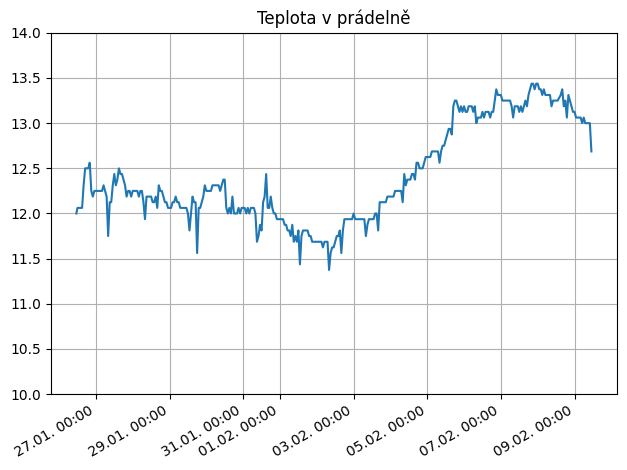

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import mplcursors

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
# df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"], linestyle="-", marker=None)
# ax.plot(df_pradelna["cas"], df_pradelna["tepl"], marker=".")
# ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=5)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()




## Import souboru Climate.csv

In [71]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV bez skiprows – tvůj soubor má jen 1 řádek hlavičky
df_climate = pd.read_csv(path)

# Převod timestamp → datetime
df_climate["time_utc"] = pd.to_datetime(df_climate["timestamp"], unit="s")

# Volitelně: vytvořit čitelný časový řetězec
df_climate["time_local"] = df_climate["time_utc"].dt.strftime("%d.%m.%Y %H:%M:%S")

# Ukázka filtrace
df_climate[df_climate["setpoint"] < 22]


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,time_utc,time_local
28,1770584707,22.1,2.6,21,False,1011.9,2026-02-08 21:05:07,08.02.2026 21:05:07
29,1770585010,22.1,2.6,21,False,1011.9,2026-02-08 21:10:10,08.02.2026 21:10:10
30,1770585307,22.1,2.5,21,False,1011.8,2026-02-08 21:15:07,08.02.2026 21:15:07
31,1770585608,22.1,2.4,21,False,1011.9,2026-02-08 21:20:08,08.02.2026 21:20:08
32,1770585906,22.1,2.4,21,False,1011.9,2026-02-08 21:25:06,08.02.2026 21:25:06
33,1770586209,22.1,2.4,21,False,1011.9,2026-02-08 21:30:09,08.02.2026 21:30:09
34,1770586506,22.1,2.3,21,False,1011.9,2026-02-08 21:35:06,08.02.2026 21:35:06
35,1770586809,22.1,2.2,21,False,1011.9,2026-02-08 21:40:09,08.02.2026 21:40:09
36,1770587106,22.1,2.2,21,False,1011.9,2026-02-08 21:45:06,08.02.2026 21:45:06
37,1770587707,22.1,2.1,21,False,1011.9,2026-02-08 21:55:07,08.02.2026 21:55:07


## Graf z Climate.csv

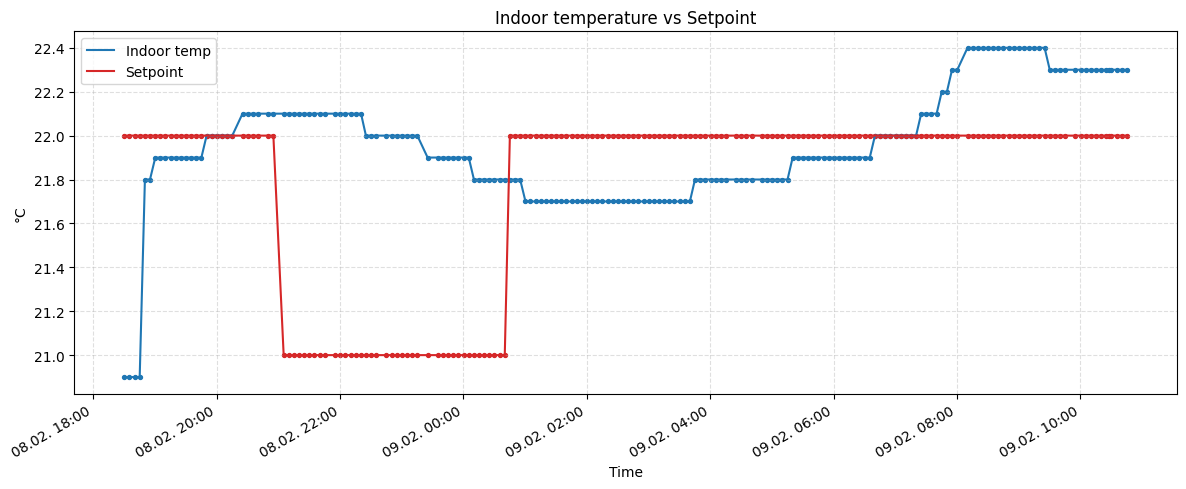

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV
df = pd.read_csv(path)

# Převod timestamp → datetime
df["time"] = pd.to_datetime(df["timestamp"], unit="s")

# -----------------------------
# GRAF
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

# Indoor teplota
ax.plot(df["time"], df["temp_indoor"],
        label="Indoor temp", color="tab:blue", linewidth=1.5)

# Setpoint
ax.plot(df["time"], df["setpoint"],
        label="Setpoint", color="tab:red", linewidth=1.5)

# Body (volitelné)
ax.scatter(df["time"], df["temp_indoor"], s=8, color="tab:blue")
ax.scatter(df["time"], df["setpoint"], s=8, color="tab:red")

# Popisky
ax.set_title("Indoor temperature vs Setpoint")
ax.set_xlabel("Time")
ax.set_ylabel("°C")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()



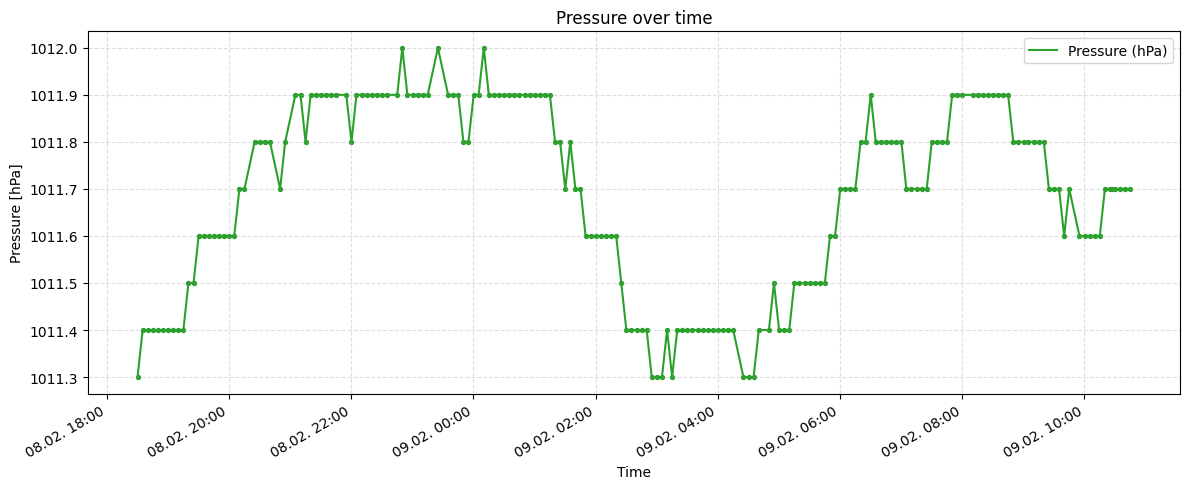

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV
df = pd.read_csv(path)

# Převod timestamp → datetime
df["time"] = pd.to_datetime(df["timestamp"], unit="s")

# -----------------------------
# GRAF TLAKU
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df["time"], df["pressure"],
        label="Pressure (hPa)", color="tab:green", linewidth=1.5)

# Body (volitelné)
ax.scatter(df["time"], df["pressure"], s=8, color="tab:green")

# Popisky
ax.set_title("Pressure over time")
ax.set_xlabel("Time")
ax.set_ylabel("Pressure [hPa]")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()
